# Exploratory Data Analysis 

Data sets:
* A sample of 1,000,000 rows of the cleansed training data
* Cleansed store transactions time series
* Cleansed oil barrel prices time series
* Dictionary of Ecuadorian national, regional and local holidays
* Dictionary of store information
* Dicitonary of item information

In [251]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime
import numpy as np

### Import the data sets

In [236]:
unitsales = pd.read_csv('../data/train_SampleForEDA.csv', header=0, low_memory=False)
transactions = pd.read_csv('../data/transactions_clean.csv', header=0)
oil = pd.read_csv('../data/oils_clean.csv', header=0)
holidays = pd.read_csv('../data/holidays_events.csv', header=0)
stores = pd.read_csv('../data/stores.csv', header=0)
items = pd.read_csv('../data/items.csv', header=0)

## Exploration of Stores

First we mapped out where the stores are located. Since we don't have precise location information we are mapping them using generic coordinates for each city with each marker indicating how many stores are located in that city.

In [5]:
locations = pd.DataFrame(columns=['city','count'])
locations['city'] = stores['city'].value_counts().index.values
locations['count'] = stores['city'].value_counts().tolist()

locations['latitude']=[-0.1807,-2.1710,-0.2389,-2.9001,-1.2543,-0.9677,-3.2581,-0.9316,
                       -0.2714,-1.0225,-2.2234,-0.3392,-1.5905,-1.6636,-0.0320,-1.8622,
                       -2.2306,-1.4924,-2.6285,-4.0079,-1.8019,-0.9682]
locations['longitude']=[-78.4678,-79.9224,-79.1774,-79.0059,-78.6229,-80.7089,-79.9554,-78.6058,
                        -79.4648,-79.4604,-80.9585,-78.1222,-78.9995,-78.6546,-78.1507,-79.9777,
                        -80.9002,-78.0024,-80.3896,-79.2113,-79.5346,-79.6517]


START = [-1.75,-78.6229]
map = folium.Map(location=START, zoom_start=7, height=500, width=900)
for index, loc in locations.iterrows():
    if loc['count']>10:
        c = 'orange'
    elif loc['count']>5:
        c = 'red'
    elif loc['count']==3:
        c='purple'
    elif loc['count']==2:
        c = 'blue'
    else:
        c='black'
    folium.Marker(location = [loc['latitude'],loc['longitude']],icon=folium.Icon(color=c),popup=str(loc['count'])).add_to(map)
display(map)

The largest number of stores are concentrated in Quito, where Corporación Favorita was founded, whereas most cities have only one or two stores. Bar charts of the counts per city and state (below) further illustrate this. City and state would thus not be useful for clustering unless combined with other information.

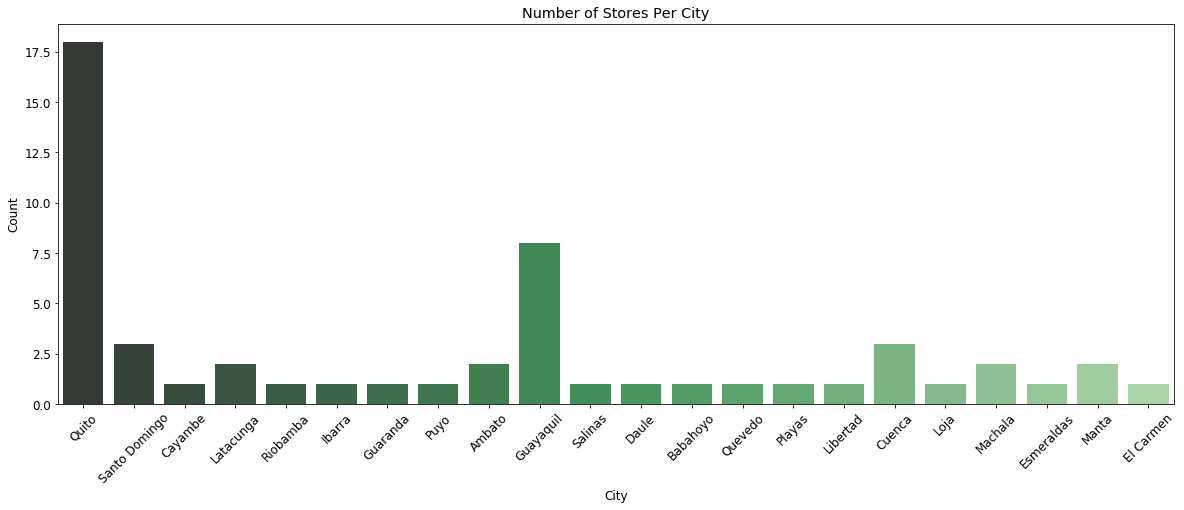

In [15]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=stores, x='city', palette="Greens_d")
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Number of Stores Per City')
plt.show()

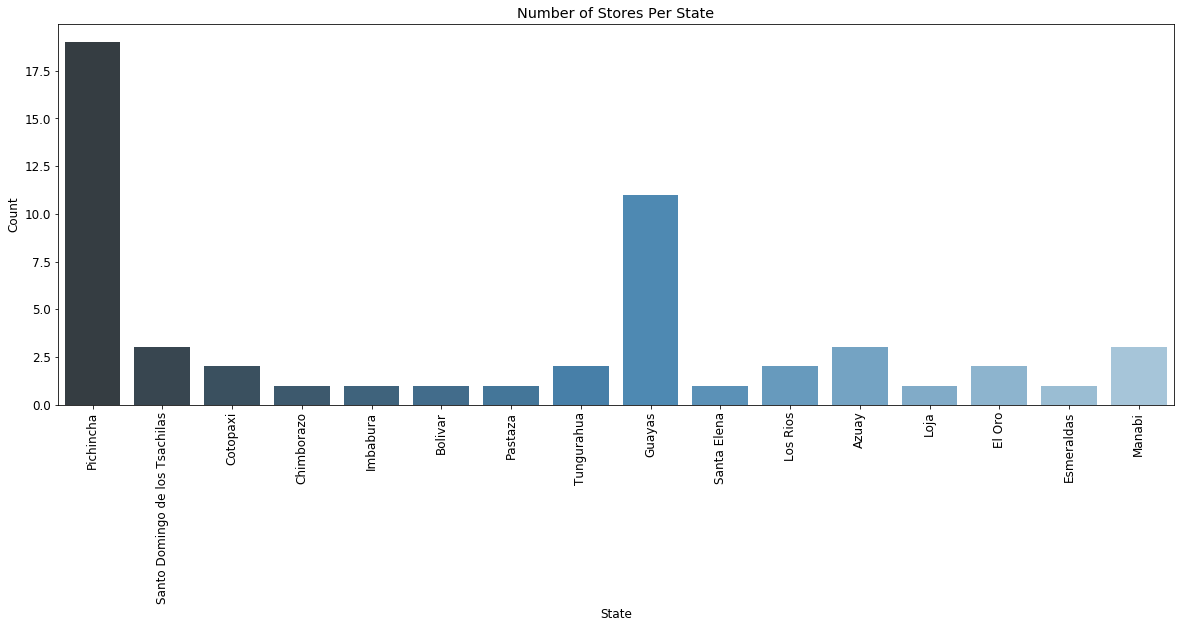

In [26]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=stores, x='state', palette="Blues_d")
plt.xticks(rotation='vertical')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Number of Stores Per State')
plt.show()

Next we examined other potential means of clustering the stores - the type and cluster columns.

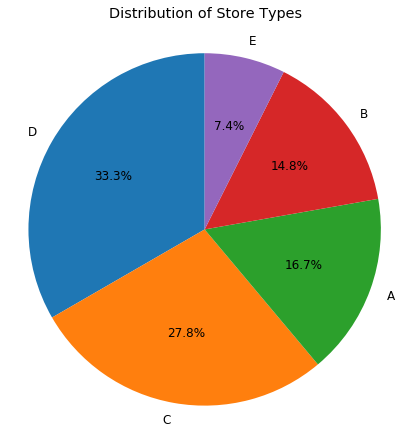

In [28]:
types = stores['type'].value_counts()


plt.close('all')
plt.figure(figsize=(7,7))
matplotlib.rcParams['font.size'] = 12.0
plt.pie(types, labels=types.index.values,autopct='%1.1f%%',startangle=90)
plt.axis('equal') 
plt.title('Distribution of Store Types\n')
plt.show()

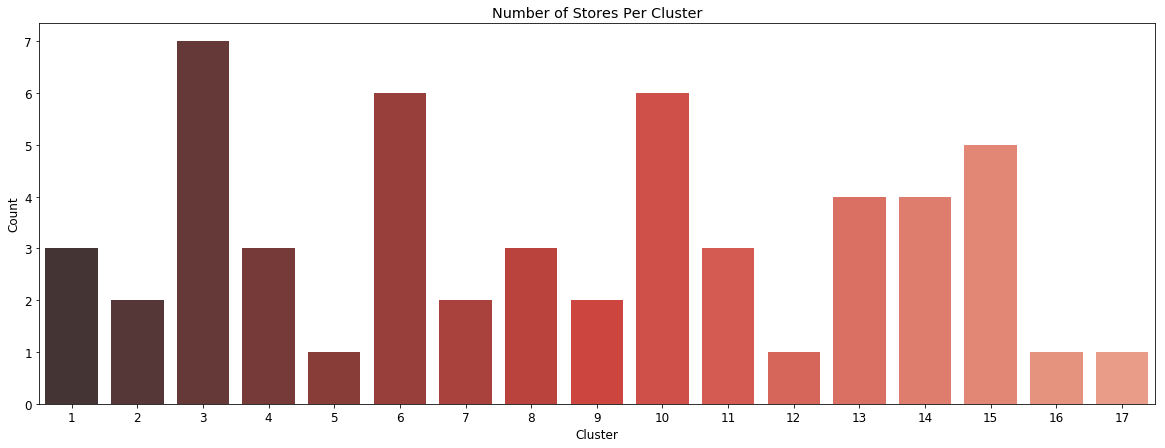

In [29]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=stores, x='cluster', palette="Reds_d")
#plt.xticks(rotation='vertical')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Stores Per Cluster')
plt.show()

Several clusters only contain one store but the type column is likely to be useful for clustering. 

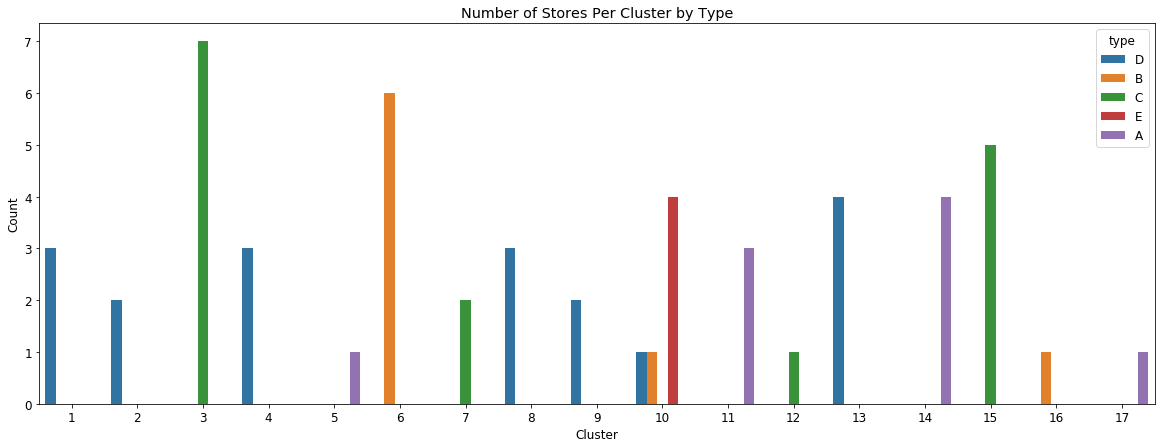

In [328]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=stores, x='cluster', hue='type')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Stores Per Cluster by Type')
plt.show()

Most cluster numbers are unique to a type, but cluster 10 corresponds to multiple types. The clusters also overlap in which states the stores are located in (below). Cluster must thus be based on some information not provided in the data set.

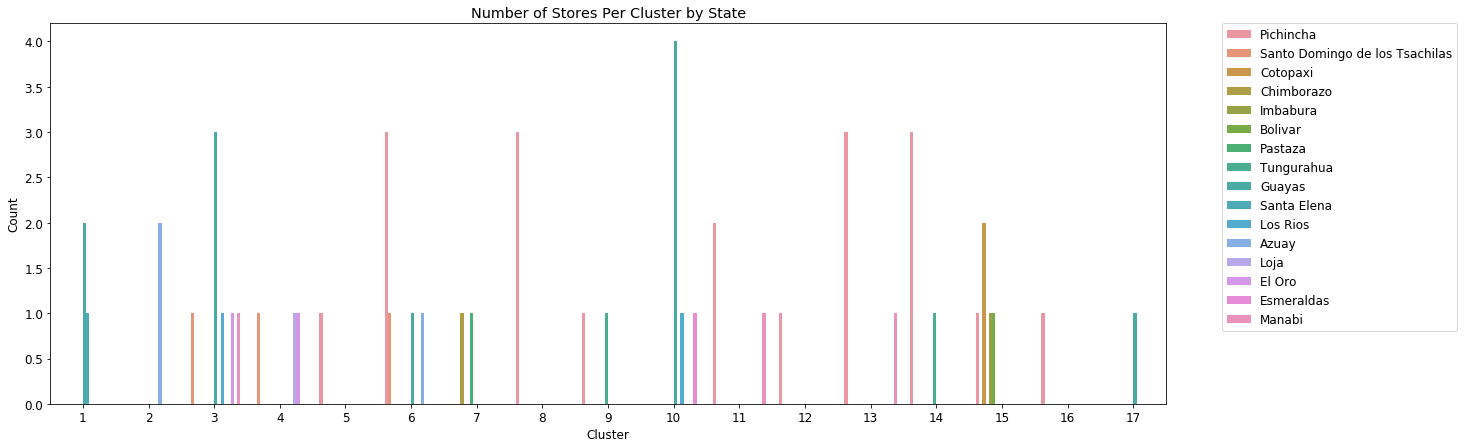

In [327]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=stores, x='cluster', hue='state')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Stores Per Cluster by State')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Exploration of Items

Similar to the store dictionary, the item dictionary contains a number of columns potentially useful for clustering though without any means of identifying what an item actually is. The columns are family, class, and a perishable flag.

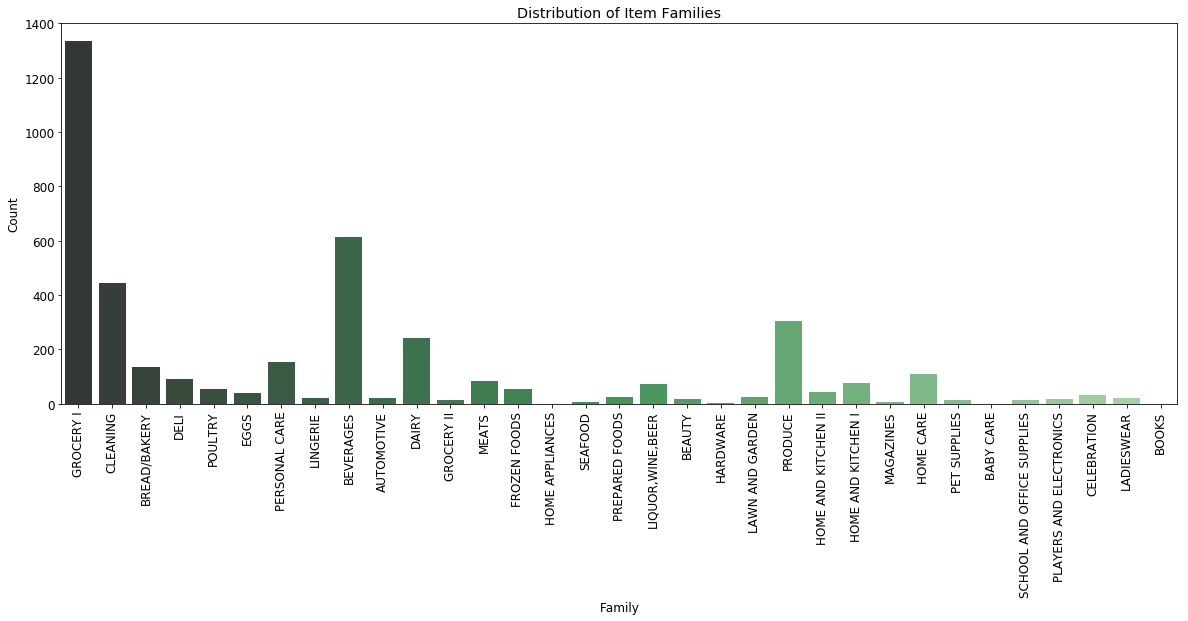

In [84]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=items, x='family', palette="Greens_d")
plt.xticks(rotation='vertical')
plt.xlabel('Family')
plt.ylabel('Count')
plt.title('Distribution of Item Families')
plt.show()

The items primarily fall within a small subset of families, with most families containing only a few items. We can more easily visualize this with a pie chart:

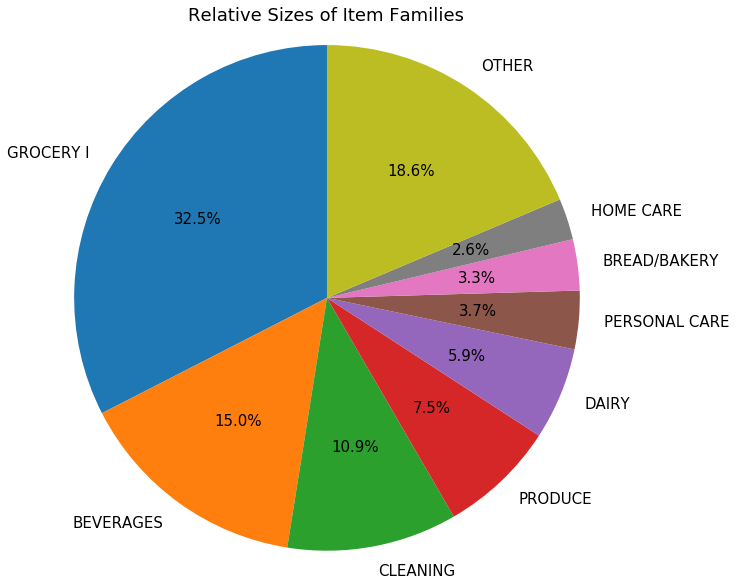

In [124]:
# Combine the families with fewer than 100 items into an "Other" category to make the pie chart readable
sizes = items['family'].value_counts()
other = sizes[sizes < 100]
sizes_adj = sizes[sizes >=100]
sizes_adj['OTHER'] = other.sum()

plt.figure(figsize=(10,10))
matplotlib.rcParams['font.size'] = 15.0
labels = sizes_adj.index.values
plt.pie(sizes_adj, labels=labels,autopct='%1.1f%%',startangle=90)
plt.title('Relative Sizes of Item Families')
plt.axis('equal') 
plt.show()

Though some of the families are likely useful for clustering, so many items fall into the larger categories we will likely need to sub-divide them. Next we look at classes and the perishable flag:

In [122]:
classes = items['class'].unique()
len(classes)

337

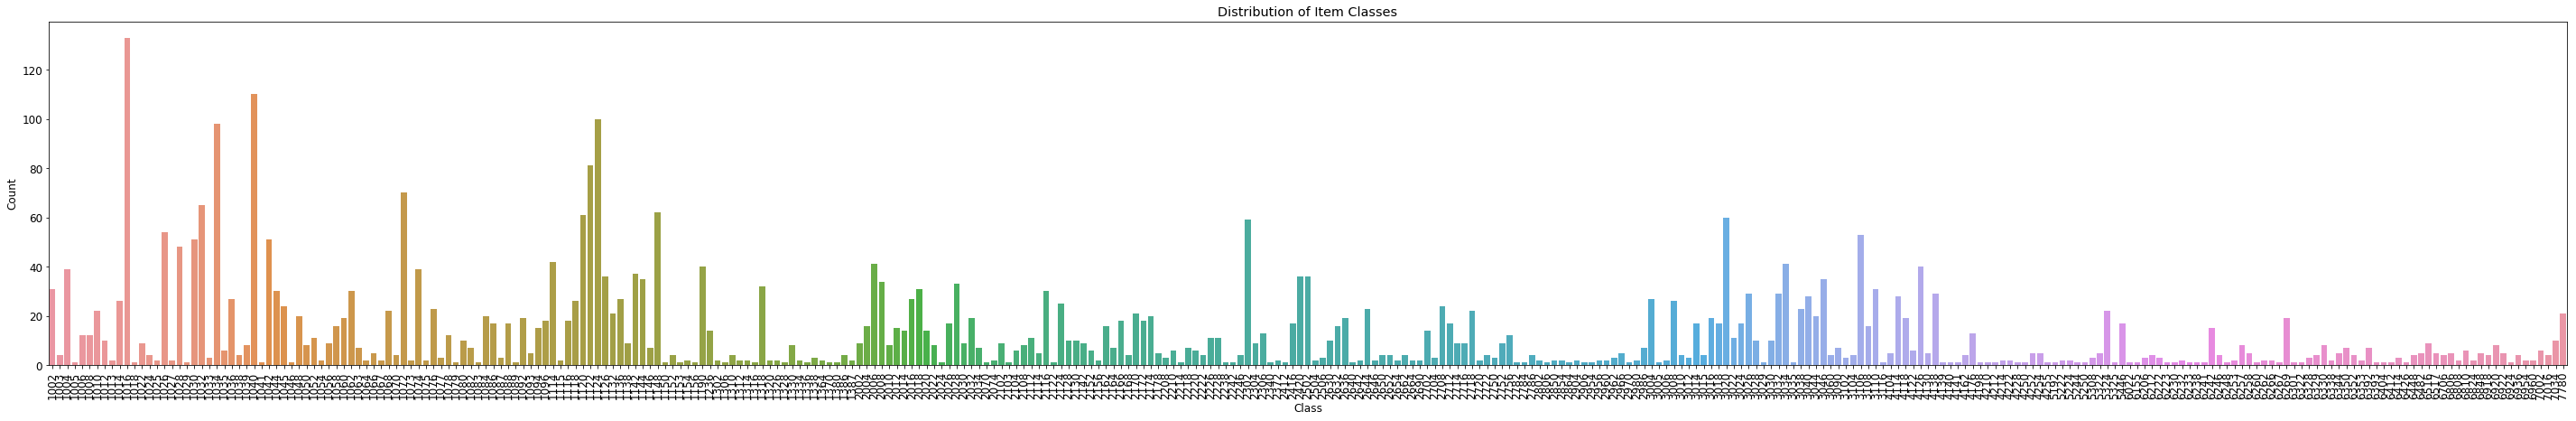

In [86]:
#grocery = items[items['family']=='GROCERY I']

plt.close('all')
plt.figure(figsize=(50,7))
#matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=items, x='class')
plt.xticks(rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Item Classes')
plt.show()

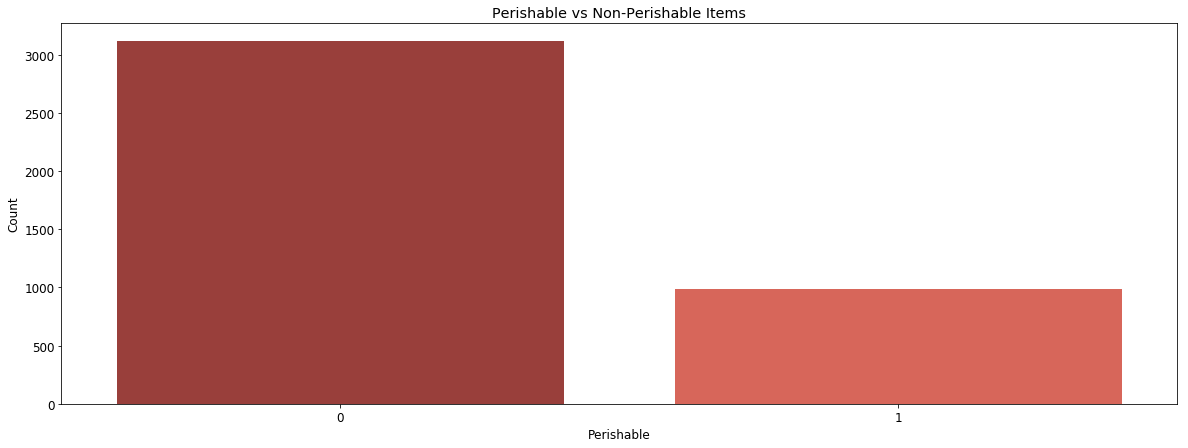

In [77]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=items, x='perishable', palette="Reds_d")
#plt.xticks(rotation='vertical')
plt.xlabel('Perishable')
plt.ylabel('Count')
plt.title('Perishable vs Non-Perishable Items')
plt.show()

#### Family-Perishable Relationship
A count plot of item families grouped by the perishable flag reveals that all items within a family are either perishable or non-perishable.

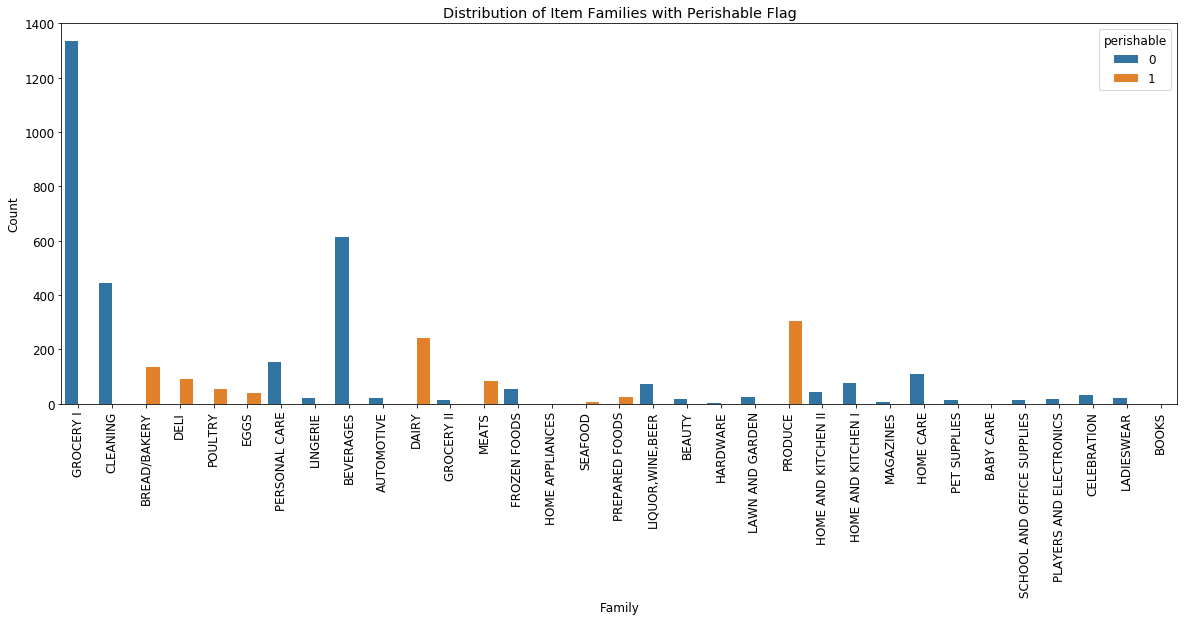

In [87]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=items, x='family', hue='perishable')
plt.xticks(rotation='vertical')
plt.xlabel('Family')
plt.ylabel('Count')
plt.title('Distribution of Item Families with Perishable Flag')
plt.show()

#### Family-Class Relationship
The class categorizations are sub-groupings within the item family. With 337 classes, it is difficult to visual this for the entire set, but we can demonstrate by example. We have selected the classes used for Grocery I and show that these classes are not used by any other family. Since 1/3 all items are Grocery I, that is likely a family we will need to further divide when clustering for which we could use these classes.

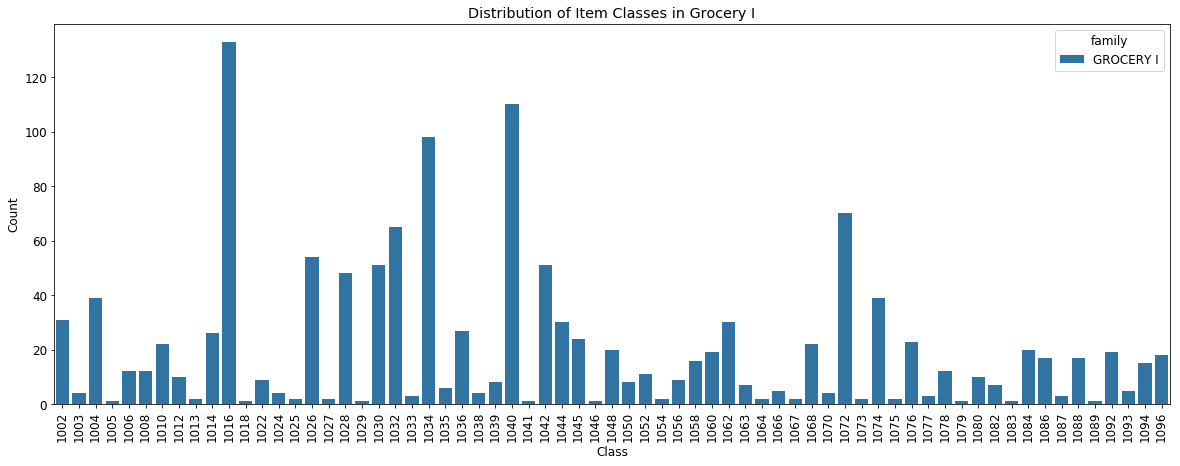

In [119]:
# filter for grocery i
gclasses = items[items['family']=='GROCERY I']
# get list of classes used by this family
gclasses = gclasses['class'].unique()
# get all tiems with those classes
itemsgc = items[items['class'].isin(gclasses)]

plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=itemsgc, x='class', hue='family')
plt.xticks(rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Item Classes in Grocery I')

plt.show()

## Exploration of Holidays

In [125]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


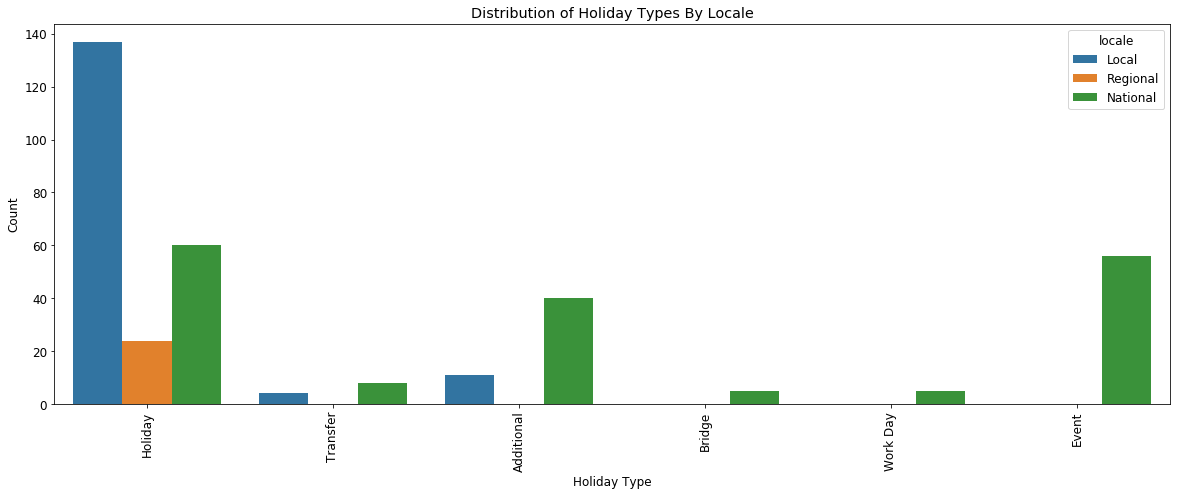

In [126]:
plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=holidays, x='type', hue='locale')
plt.xticks(rotation='vertical')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.title('Distribution of Holiday Types By Locale')
plt.show()

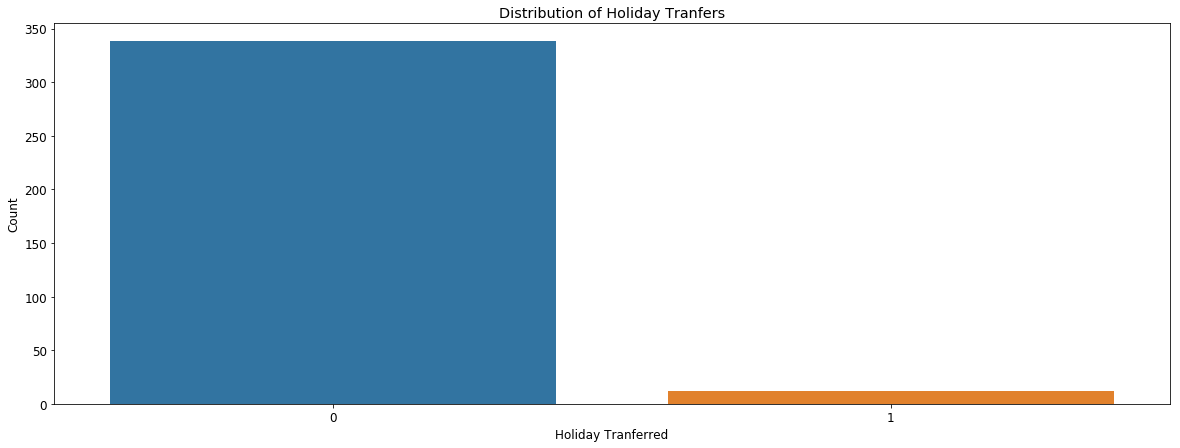

In [132]:
def tran(x):
    if x:
        return 1
    else:
        return 0

holidays['transferred'] = holidays['transferred'].map(lambda x: tran(x))

plt.close('all')
plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=holidays, x='transferred')
#plt.xticks(rotation='vertical')
plt.xlabel('Holiday Tranferred')
plt.ylabel('Count')
plt.title('Distribution of Holiday Tranfers')
plt.show()

In [137]:
local = holidays[holidays['locale']=='Local']
regional = holidays[holidays['locale']=='Regional']
national = holidays[holidays['locale']=='National']

#### National 
An examination of the names and frequencies of the national holidays reflects both major religious and cultural holidays (Christmas, New Years, Carnaval, Ecuadorian War of Independence), days significant in retail (countdown to Christmas, Black Friday), and prominent events that had an impact on the economy (the World Cup in Brazil, the 2016 earthquake).

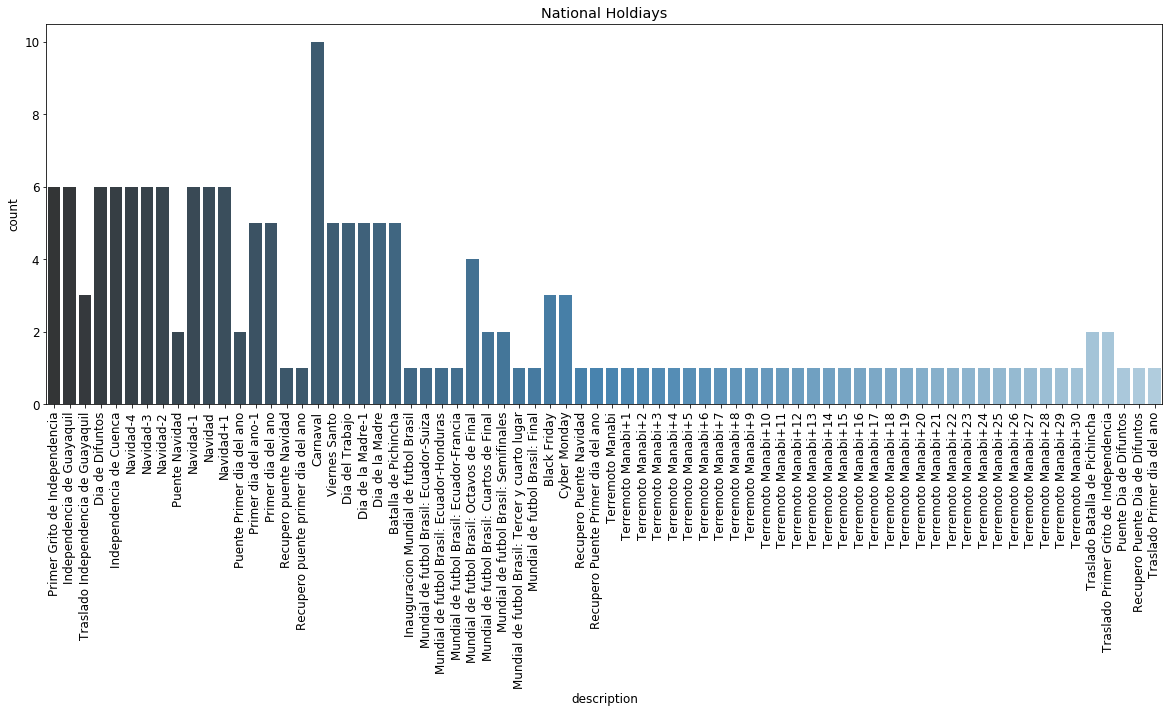

In [157]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=national, x='description', palette='Blues_d')
plt.xticks(rotation='vertical')
plt.title('National Holdiays')
plt.show()

#### Local
In examining the local holidays, most mark foundings and creation of municipalities, as well as a few dates from the war of independence.

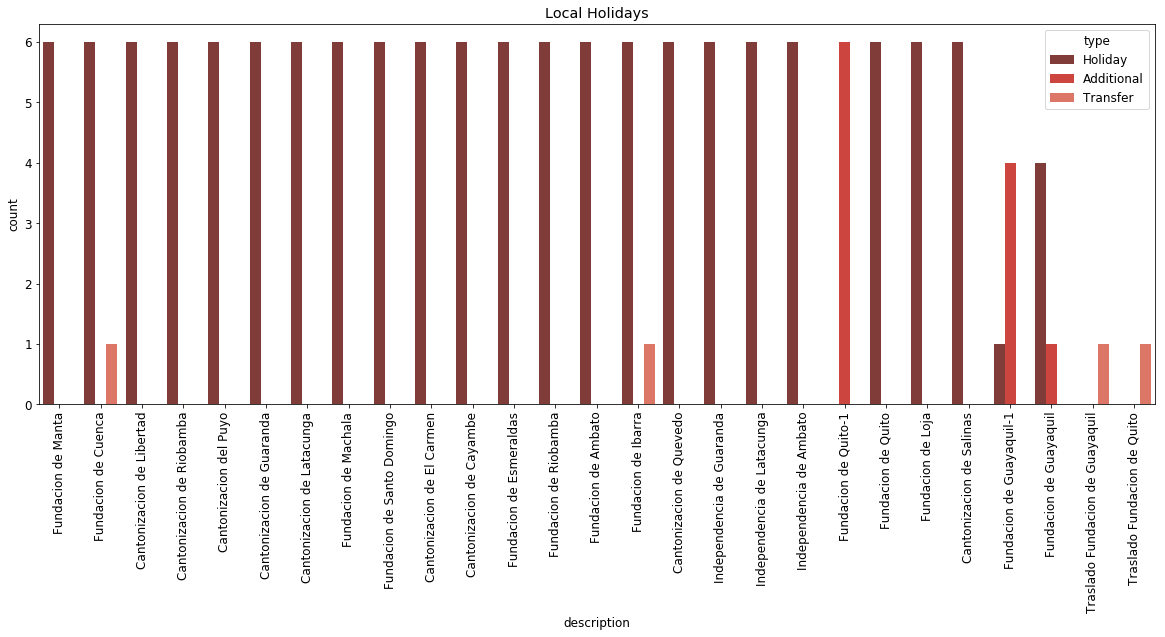

In [159]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=local, x='description', hue='type', palette="Reds_d")
plt.xticks(rotation='vertical')
plt.title('Local Holidays')
plt.show()

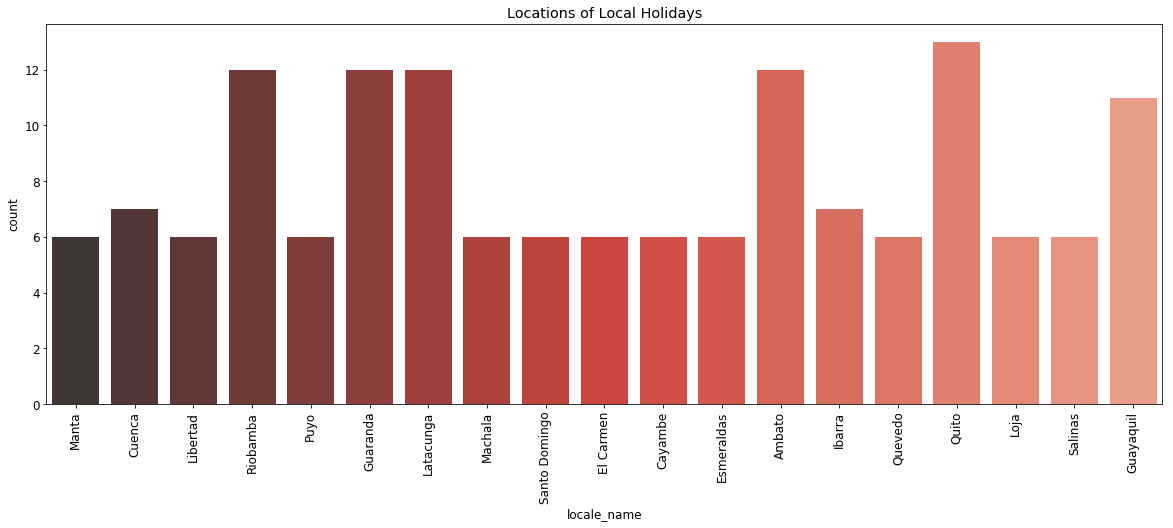

In [162]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=local, x='locale_name', palette="Reds_d")
plt.xticks(rotation='vertical')
plt.title('Locations of Local Holidays')
plt.show()

#### Regional
The regional holidays all mark the creation of provinces.

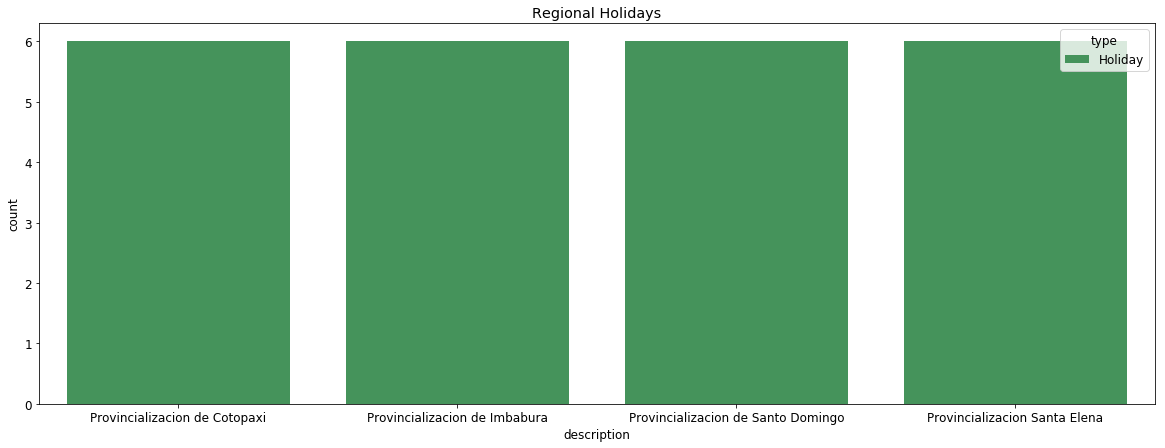

In [165]:
plt.close('all')

plt.figure(figsize=(20,7))
matplotlib.rcParams['font.size'] = 12.0
sns.countplot(data=regional, x='description', hue='type', palette="Greens_d")
#plt.xticks(rotation=45)
plt.title('Regional Holidays')
plt.show()

## Exploration of Transactions
First we will look at the general shape and distribution of the data.

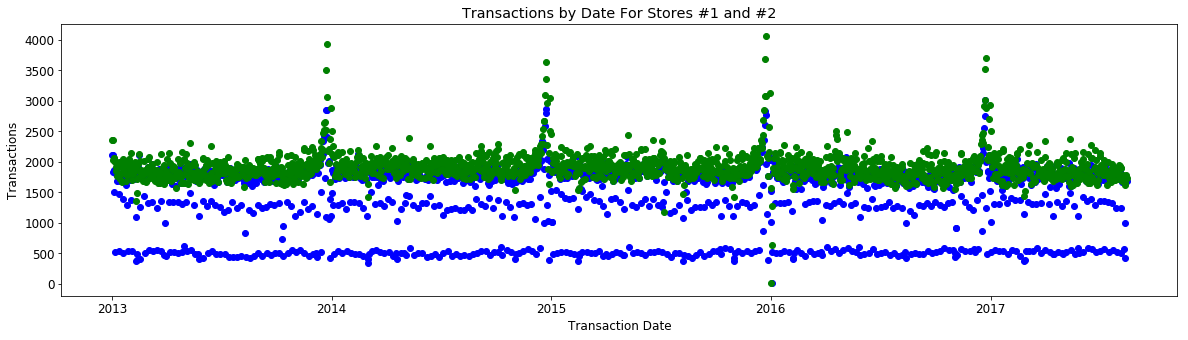

In [177]:
transactions['formatteddate'] = transactions['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))

plt.close('all')
plt.figure(figsize=(20,5))
plt.plot_date(transactions.formatteddate, transactions['1'], color='b')
plt.plot_date(transactions.formatteddate, transactions['2'], color='g')

plt.title('Transactions by Date For Stores #1 and #2')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')
plt.show()

Store #1 shows three bands, most likely representing different days of the week whereas store #2 shows a more consistent transaction count. Both have large spikes around Christmas.

In [215]:
transactions.drop('formatteddate', axis=1, inplace=True)
trplt = transactions.melt(id_vars=['date'])
trplt = trplt.rename(columns={'date':'date','variable':'store_nbr','value':'transactions'})

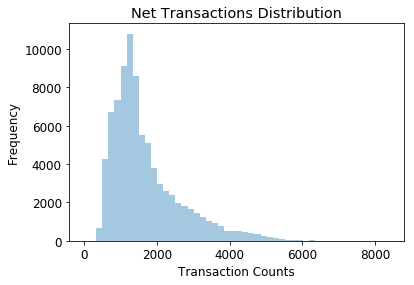

In [181]:
trplt.dropna(inplace=True)

plt.close('all')
sns.distplot(trplt['transactions'], kde=False)
plt.xlabel('Transaction Counts')
plt.ylabel('Frequency')
plt.title('Net Transactions Distribution')
plt.show()

The distribution has a long tail, likely reflecting holiday shopping.

#### Mean Transactions by Store Type
With the transaction data we can now gain a better understanding of what the store types are. 

In [ ]:
plt.close('all')
sns.countplot(x='transactions', data=trplt, hue='store_nbr')
plt.xlabel('Transaction Counts')
plt.ylabel('Frequency')
plt.title('Net Transactions Distribution')
plt.show()

/Users/emily-air13/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


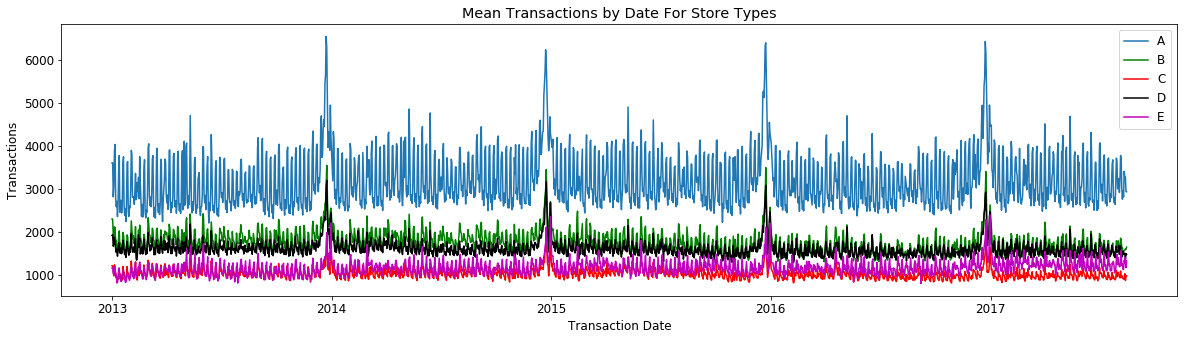

In [173]:
# Switch the columns and rows so that the data can be joined with store type
transactions = transactions.set_index('date').T
s = stores[['store_nbr','type']]
s['store_nbr'] = s['store_nbr'].map(lambda x: int(x))
transactions['store_nbr']=transactions.index
transactions.reset_index()
transactions['store_nbr'] = transactions['store_nbr'].map(lambda x: int(x))

# Add the store types
transactions = transactions.merge(s, how='left', on='store_nbr')
transactions2 = transactions.drop('store_nbr', axis=1)

# Separate based on type
transactionsA = transactions2[transactions2['type']=='A'].drop('type', axis=1)
transactionsB = transactions2[transactions2['type']=='B'].drop('type', axis=1)
transactionsC = transactions2[transactions2['type']=='C'].drop('type', axis=1)
transactionsD = transactions2[transactions2['type']=='D'].drop('type', axis=1)
transactionsE = transactions2[transactions2['type']=='E'].drop('type', axis=1)

# Reformat the dataframes for plotting
transactionsA = transactionsA.T
transactionsB = transactionsB.T
transactionsC = transactionsC.T
transactionsD = transactionsD.T
transactionsE = transactionsE.T

format = '%Y-%m-%d'
transactionsA['date'] = transactionsA.index.values
transactionsA['date'] = transactionsA['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
transactionsA = transactionsA.set_index('date')

transactionsB['date'] = transactionsB.index.values
transactionsB['date'] = transactionsB['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
transactionsB = transactionsB.set_index('date')

transactionsC['date'] = transactionsC.index.values
transactionsC['date'] = transactionsC['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
transactionsC = transactionsC.set_index('date')

transactionsD['date'] = transactionsD.index.values
transactionsD['date'] = transactionsD['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
transactionsD = transactionsD.set_index('date')

transactionsE['date'] = transactionsE.index.values
transactionsE['date'] = transactionsE['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
transactionsE = transactionsE.set_index('date')

# Calculate the daily mean for each store type
transactionsA['mean'] = transactionsA.mean(axis=1)
transactionsB['mean'] = transactionsB.mean(axis=1)
transactionsC['mean'] = transactionsC.mean(axis=1)
transactionsD['mean'] = transactionsD.mean(axis=1)
transactionsE['mean'] = transactionsE.mean(axis=1)

# Plot the results
plt.close('all')
plt.figure(figsize=(20,5))
plt.plot(transactionsA.index.values, transactionsA['mean'], label='A')
plt.plot(transactionsB.index.values, transactionsB['mean'], color='g', label='B')
plt.plot(transactionsC.index.values, transactionsC['mean'], color='r', label='C')
plt.plot(transactionsD.index.values, transactionsD['mean'], color='k', label='D')
plt.plot(transactionsE.index.values, transactionsE['mean'], color='m', label='E')

plt.title('Mean Transactions by Date For Store Types')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')

plt.legend()
plt.show()

We again see the spike around the Christmas holidays. We can also see that store type is related to the number of daily transactions. Most likely it is an indicator of the size of the store, though since B & D, and C & E overlap there is likely an additional factor. 

#### Influence of Holidays on Net Transactions

In [188]:
unitsales['holidaytype'] = unitsales['holidaytype'].fillna('None') 
unitsales['holidaytype_r'] = unitsales['holidaytype_r'].fillna('None') 
unitsales['holidaytype_n'] = unitsales['holidaytype_n'].fillna('None') 

def holiday(x, y, z):
    if (x =='None' and y=='None' and z=='None'):
        return 0
    else:
        return 1
    
unitsales['holiday'] = unitsales.apply(lambda x: holiday(x['holidaytype'], x['holidaytype_r'], x['holidaytype_n']), axis=1)

In [193]:
def holiday2(x, y, z):
    if (x !='None'):
        return 'National ' + x
    elif (y !='None'):
        return 'Regional ' + y
    elif(z !='None'):
        return 'Local ' + z
    else:
        return 'None'
    
unitsales['holiday2'] = unitsales.apply(lambda x: holiday2(x['holidaytype_n'], x['holidaytype_r'], x['holidaytype']), axis=1)

In [216]:
tmp = unitsales[['date','store_nbr','holiday','holiday2']]
tmp.drop_duplicates()
tmp['date'] = tmp['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
tmp['store_nbr'] = tmp['store_nbr'].map(lambda a: int(a))
trplt['date'] = trplt['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
trplt['store_nbr'] = trplt['store_nbr'].map(lambda a: int(a))

trplt = trplt.merge(tmp, on=['date', 'store_nbr'], how='left')
trplt['holiday'].fillna(0, inplace=True)

/Users/emily-air13/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/emily-air13/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


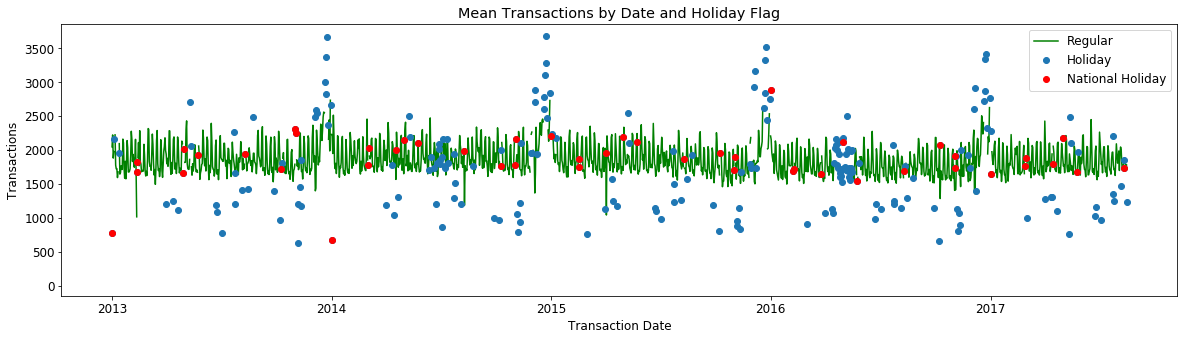

In [221]:
trpltholidays = trplt[trplt['holiday']==1]
trpltregular = trplt[trplt['holiday']==0]
trpltnational = trplt[trplt['holiday2']=='National Holiday']

trpltholidaysm = pd.DataFrame({'mean' : trpltholidays.groupby("date")['transactions'].mean()}).reset_index()
trpltregularm = pd.DataFrame({'mean' : trpltregular.groupby("date")['transactions'].mean()}).reset_index()
trpltnationalm = pd.DataFrame({'mean' : trpltnational.groupby("date")['transactions'].mean()}).reset_index()

plt.close('all')
plt.figure(figsize=(20,5))

plt.plot(trpltregularm['date'], trpltregularm['mean'], color='g', label='Regular')
plt.plot_date(trpltholidaysm['date'], trpltholidaysm['mean'], label='Holiday')
plt.plot_date(trpltnationalm['date'], trpltnationalm['mean'], color='r', label='National Holiday')

plt.title('Mean Transactions by Date and Holiday Flag')
plt.xlabel('Transaction Date')
plt.ylabel('Transactions')

plt.legend()
plt.show()


National holidays do not appear to have a strong effect on transactions, however other events within the "holidays" dictionary do. We can see the spike around Christmas, most likely the countdown days tracked in that data set. Other events correspond to lower sales. This could be due to fewer people shopping on those days, or it could be a selection bias - there are many local holidays within the data set and if the local holidays are happening in regions with lower sales on average the data would be reflecting that average rather than an effect of the holiday. This is something we will have to look in our feature selection.

## Exploration of Unit Sales (Train Data)
First we will look at the distribution of unit sale values.

In [238]:
# Remove outliers
unitsales = unitsales[unitsales['unit_sales']<1000]
unitsales = unitsales[unitsales['unit_sales']>-1000]

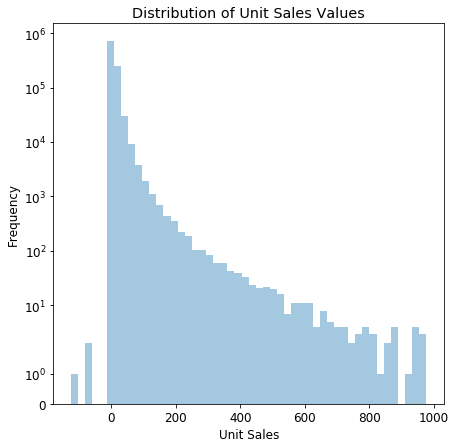

In [276]:
plt.close('all')
fig,ax=plt.subplots(figsize=(7, 7))
ax.set(yscale="symlog")
sns.distplot(unitsales['unit_sales'].values, bins=50, kde=False)
plt.xlabel('Unit Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Unit Sales Values')
plt.show()

It is important to note that some items are sold by weight. 400 is thus likely not 400 items, but 400g of an item. We don't know scale (g vs kg), and we also have no way of identifying which items are sold by weight. Clustering should help with this.

Next we looked at changes in unit sales totals over time.

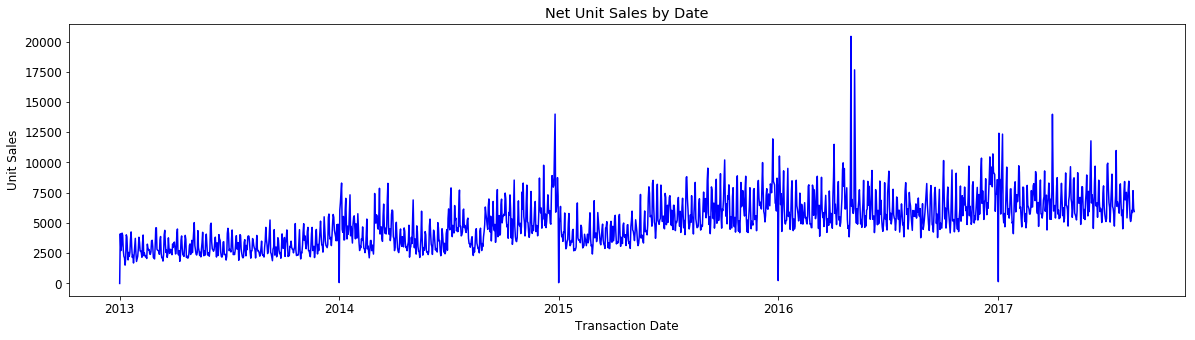

In [242]:
totals = unitsales.groupby('date')['unit_sales'].sum()
totals = pd.DataFrame({'date': totals.index.values, 'mean': totals.values})
totals['date'] = totals['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))

plt.close('all')

plt.figure(figsize=(20,5))
plt.plot(totals['date'], totals['mean'], c = 'blue')

plt.title('Net Unit Sales by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Unit Sales')

plt.show()

The general upward trend reflects the grocery store chain's opening of new locations.

If we look at total unit sales by item number we can see that most items have smaller totals, while some are quite large.

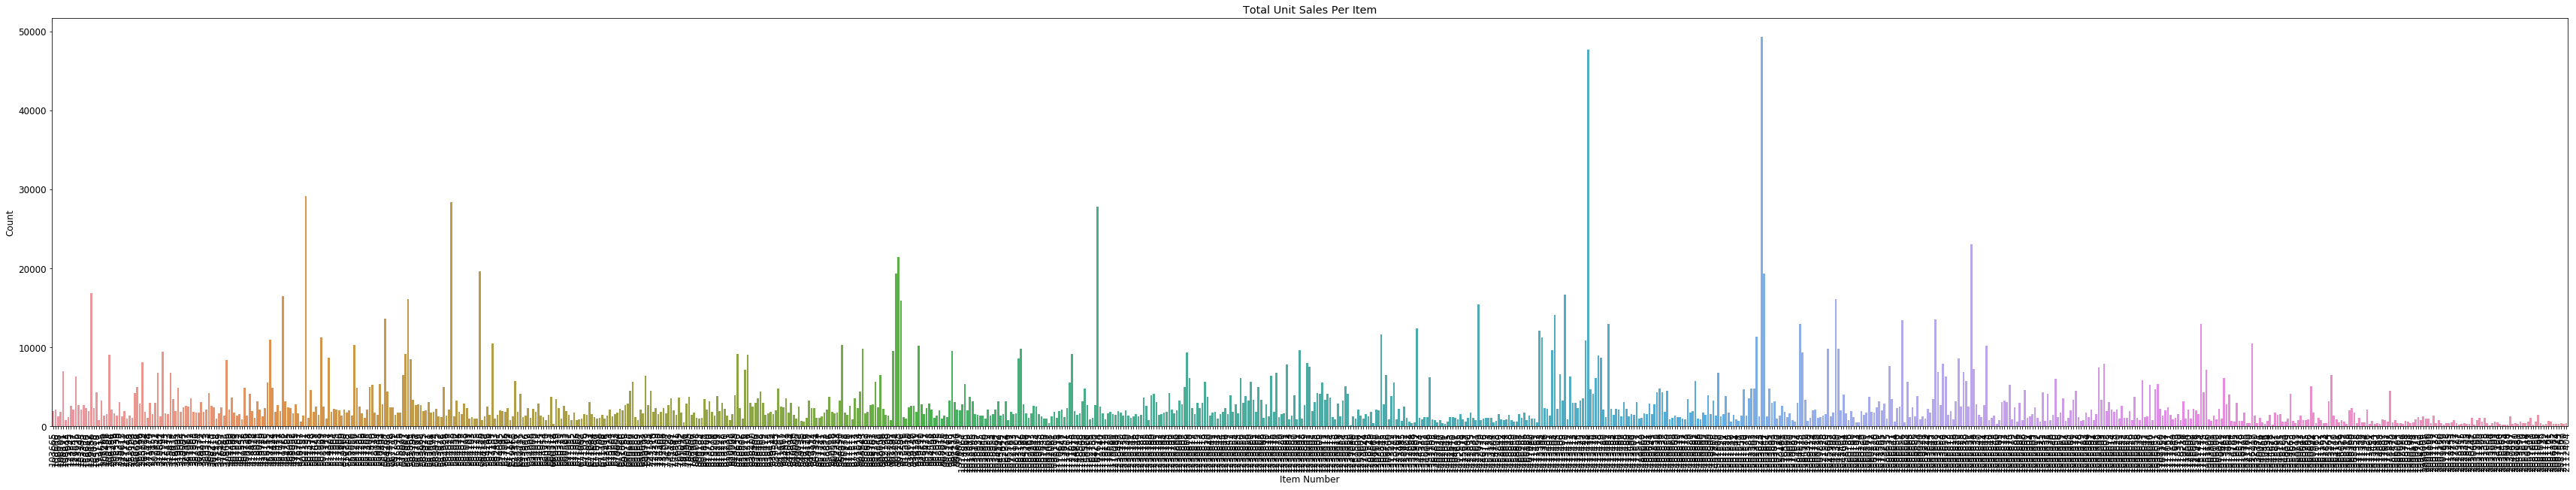

In [275]:
item_totals = pd.DataFrame({'count' : perishable.groupby('item_nbr')['unit_sales'].sum()}).reset_index()


plt.close('all')
plt.figure(figsize=(60, 10))
sns.barplot(x=item_totals['item_nbr'], y=item_totals['count'], data=item_totals)
plt.xticks(rotation='vertical')
plt.title('Total Unit Sales Per Item')
plt.xlabel('Item Number')
plt.ylabel('Count')
plt.show()

If we examine the mean unit sale value for each item, we can see that the large totals generally correspond to items sold in larger units. These likely correspond to the items sold by weight.

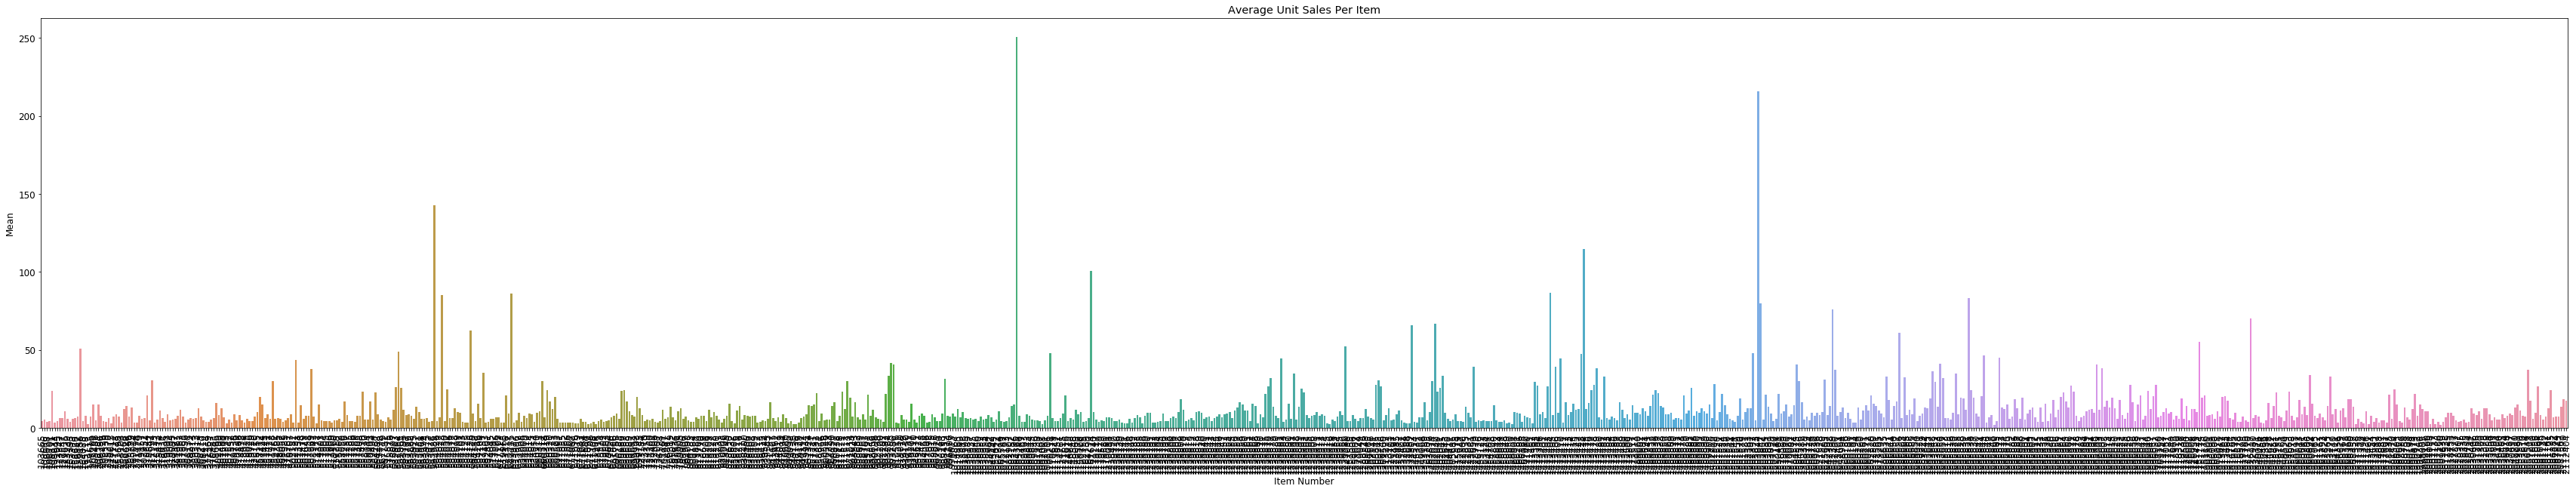

In [305]:
item_means = pd.DataFrame({'mean' : perishable.groupby('item_nbr')['unit_sales'].mean()}).reset_index()


plt.close('all')
plt.figure(figsize=(60, 10))
sns.barplot(x=item_means['item_nbr'], y=item_means['mean'], data=item_means)
plt.xticks(rotation='vertical')
plt.title('Average Unit Sales Per Item')
plt.xlabel('Item Number')
plt.ylabel('Mean')
plt.show()

In looking at the unit sales distribution across stores, we can see a similar skew in the data but also there are differences in how much of a skew each store has.

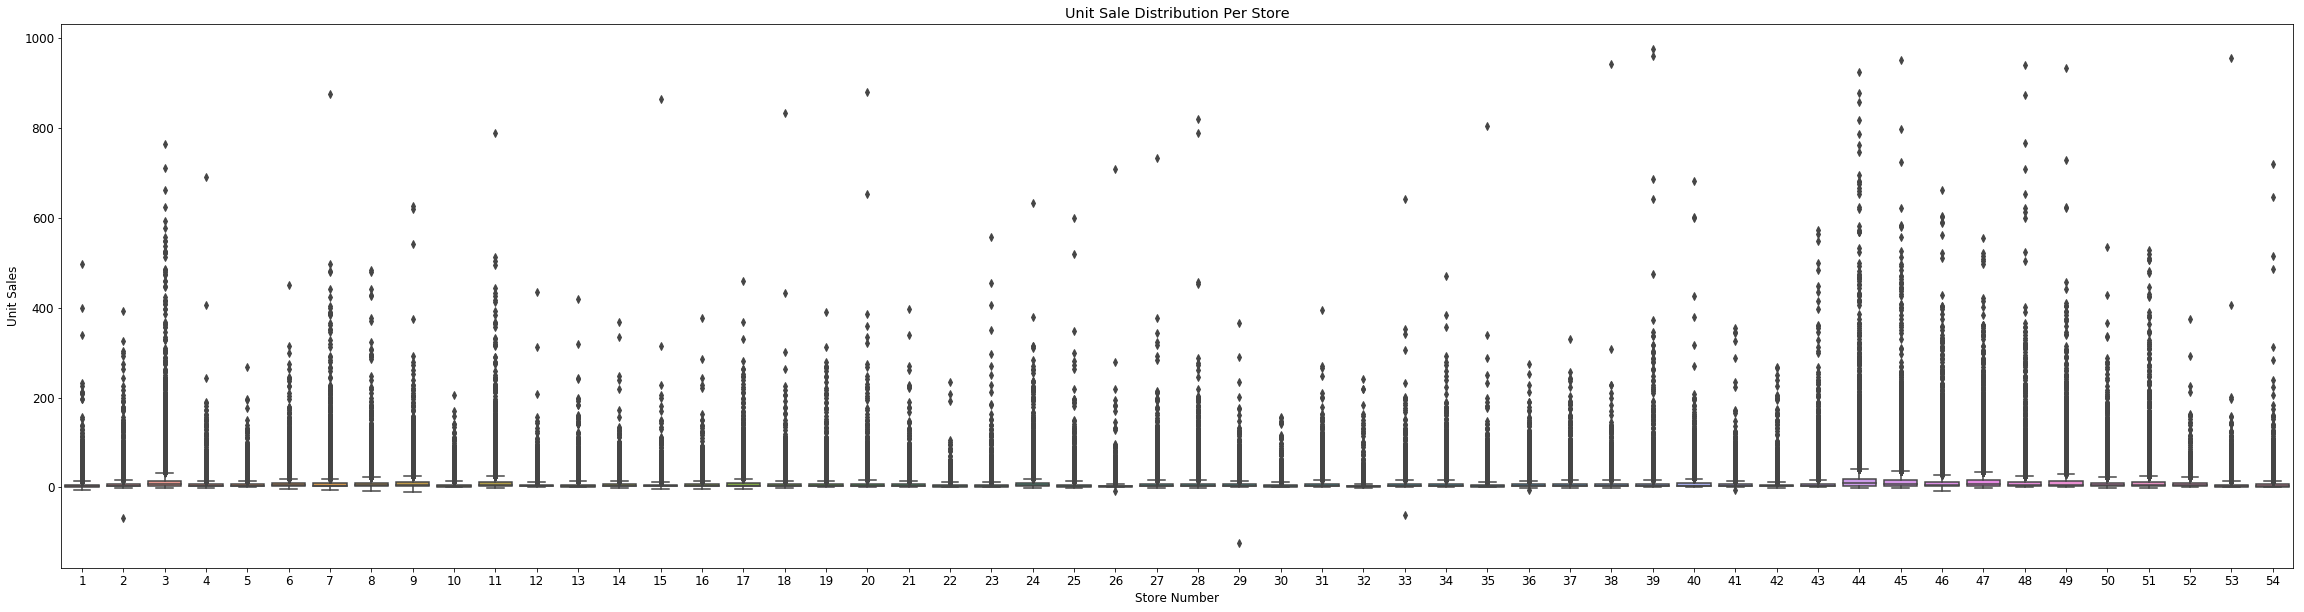

In [277]:
plt.close('all')
plt.figure(figsize=(40,10))
sns.boxplot(y='unit_sales', x='store_nbr', data=unitsales)
plt.title('Unit Sale Distribution Per Store')
plt.xlabel('Store Number')
plt.ylabel('Unit Sales')
plt.show()

#### Item Promotions

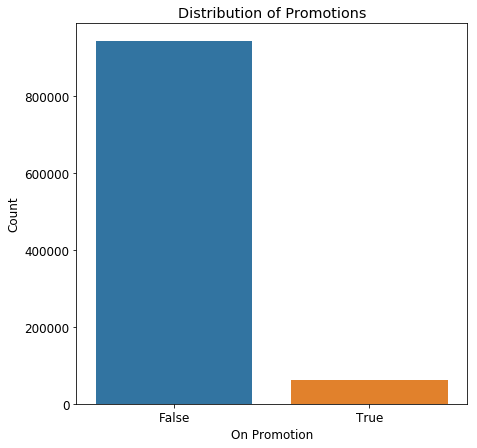

In [278]:
promo_totals = unitsales['onpromotion'].value_counts()
promo = pd.DataFrame(columns=['onpromotion','count'])
promo['onpromotion'] = promo_totals.index.values
promo['count'] = promo_totals.values

plt.close('all')
fig,ax=plt.subplots(figsize=(7, 7))
sns.barplot(x=promo['onpromotion'], y=promo['count'])
plt.title('Distribution of Promotions')
plt.xlabel('On Promotion')
plt.ylabel('Count')
plt.show()

Most of the items are not being promoted when they are purchased. However, whether or not an item is being promoted does seem to have a small positive effect on unit sales as shown below.

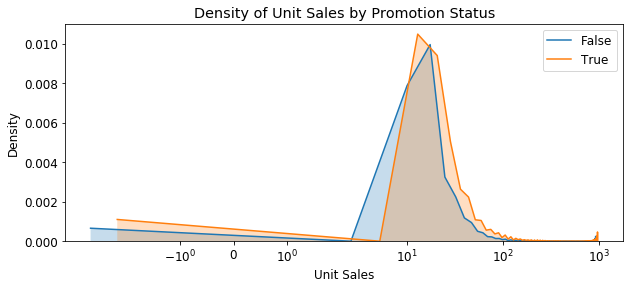

In [280]:
falsepromo = unitsales[unitsales['onpromotion']==False]
truepromo = unitsales[unitsales['onpromotion']==True]

# Make sample sizes equal
falsepromo = falsepromo.sample(n=62517)
falsepromo = falsepromo['unit_sales']
truepromo = truepromo['unit_sales']

plt.close('all')
fig,ax=plt.subplots(figsize=(10, 4))
ax.set(xscale="symlog")

sns.kdeplot(falsepromo, shade=True, label='False')
sns.kdeplot(truepromo, shade=True, label='True')
plt.title('Density of Unit Sales by Promotion Status')
plt.xlabel('Unit Sales')
plt.ylabel('Density')
plt.show()

### Perishable vs Non-Perishable Items
Next we examined the effect of whether or not an item is perishable on unit sales.

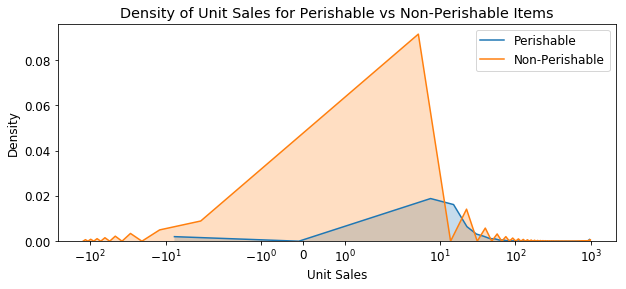

In [283]:
perishable = unitsales[unitsales['perishable']==1]
nonperishable = unitsales[unitsales['perishable']==0]

p = perishable['unit_sales']
n = nonperishable['unit_sales']

plt.close('all')
fig,ax=plt.subplots(figsize=(10, 4))
ax.set(xscale="symlog")

sns.kdeplot(p, shade=True, label='Perishable')
sns.kdeplot(n, shade=True, label='Non-Perishable')
plt.title('Density of Unit Sales for Perishable vs Non-Perishable Items')
plt.xlabel('Unit Sales')
plt.ylabel('Density')

plt.show()

Most items are not perishable as reflected in the height of each density graph, but the perishable item unit counts are skewed towards larger numbers. We assume this is due to the fact that perishable items are more likely to be sold by weight.

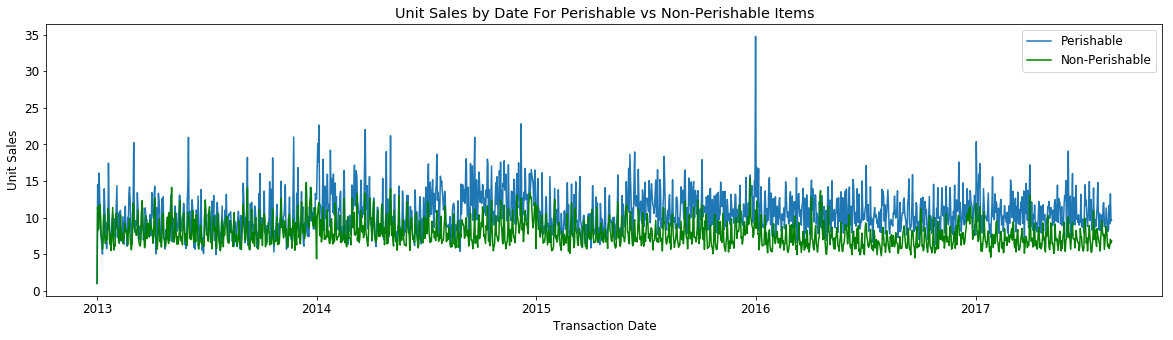

In [308]:
perishable = unitsales[unitsales['perishable']==1]
nonperishable = unitsales[unitsales['perishable']==0]

p = pd.DataFrame({'mean' : perishable.groupby('date')['unit_sales'].mean()}).reset_index()
n = pd.DataFrame({'mean' : nonperishable.groupby('date')['unit_sales'].mean()}).reset_index()

p['date'] = p['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))
n['date'] = n['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))

plt.close('all')
plt.figure(figsize=(20,5))

plt.plot(p['date'], p['mean'], label = 'Perishable')
plt.plot(n['date'], n['mean'], color='g', label='Non-Perishable')

plt.title('Unit Sales by Date For Perishable vs Non-Perishable Items')
plt.xlabel('Transaction Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

Perishable items do have a higher average unit count over time.

### Effects of Time Variables on Unit Sales

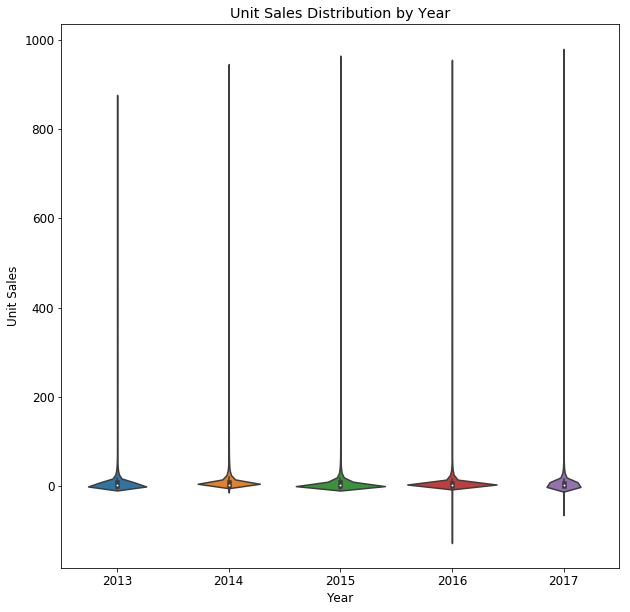

In [284]:

plt.close('all')
plt.figure(figsize=(10,10))
sns.violinplot(y='unit_sales', x='year', data=unitsales)
plt.xlabel('Year')
plt.ylabel('Unit Sales')
plt.title('Unit Sales Distribution by Year')
plt.show()

Year has little effect on unit sales, though it is noteworthy that returns were more common in 2016.

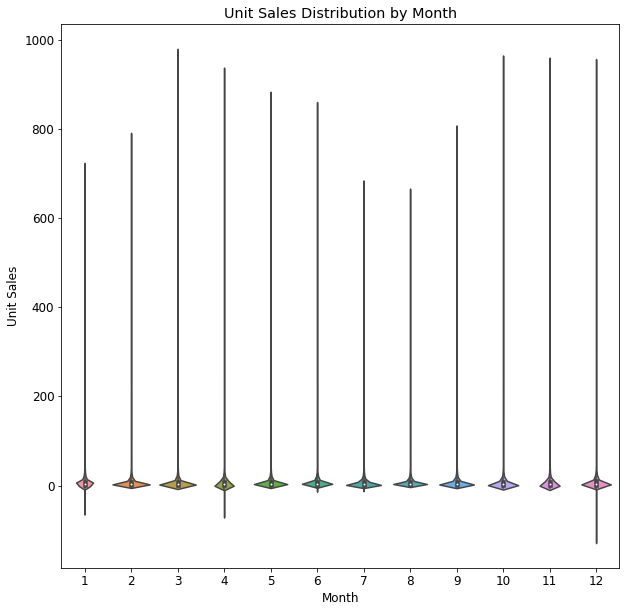

In [285]:
plt.close('all')
plt.figure(figsize=(10,10))
sns.violinplot(y='unit_sales', x='month', data=unitsales)
plt.xlabel('Month')
plt.ylabel('Unit Sales')
plt.title('Unit Sales Distribution by Month')
plt.show()

There does appear to be a seasonal effect on unit sales, with the large ranges occurring in spring and fall. 

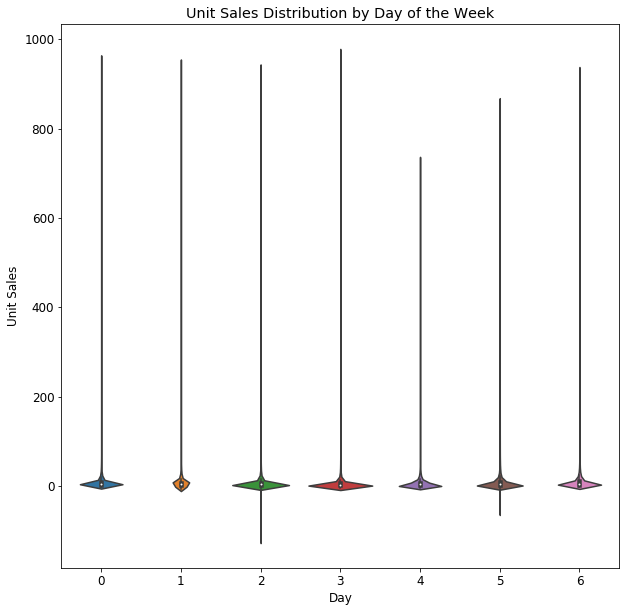

In [318]:
plt.close('all')
plt.figure(figsize=(10,10))
sns.violinplot(y='unit_sales', x='day', data=unitsales)
plt.xlabel('Day')
plt.ylabel('Unit Sales')
plt.title('Unit Sales Distribution by Day of the Week')
plt.show()

There is also an effect of day of the week on unit sales. We can look at the interaction of day of the week and month with a heatmap:

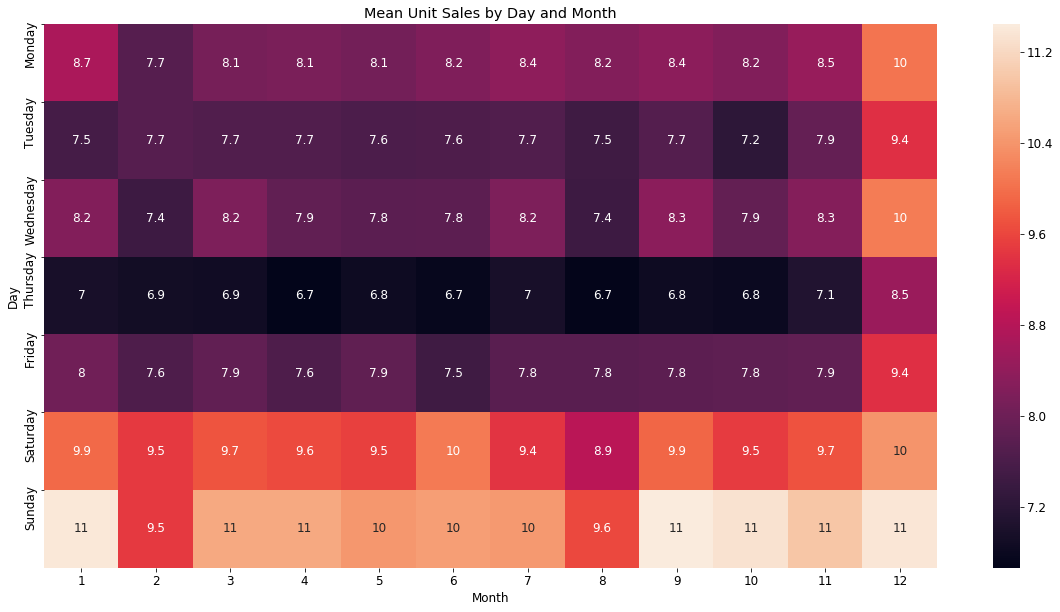

In [316]:
time = unitsales[['day','month','unit_sales']]
time = pd.pivot_table(time, values=['unit_sales'], index=['day'], columns=['month'], aggfunc=np.mean)
time = pd.DataFrame(time.to_records())
time.columns = [hdr.replace("('unit_sales', ","").replace(")", "") for hdr in time.columns]
time.drop('day', axis=1, inplace=True)


plt.close('all')
plt.figure(figsize=(20,10))
sns.heatmap(time, annot=True)
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.yticks(time.index.values, labels)
plt.ylabel('Day')
plt.xlabel('Month')
plt.title('Mean Unit Sales by Day and Month')
plt.show()

A similar analysis on the transaction data reveals the overall trend: there are more transactions and items are purchased in larger quantities on weekends and during the month of December.

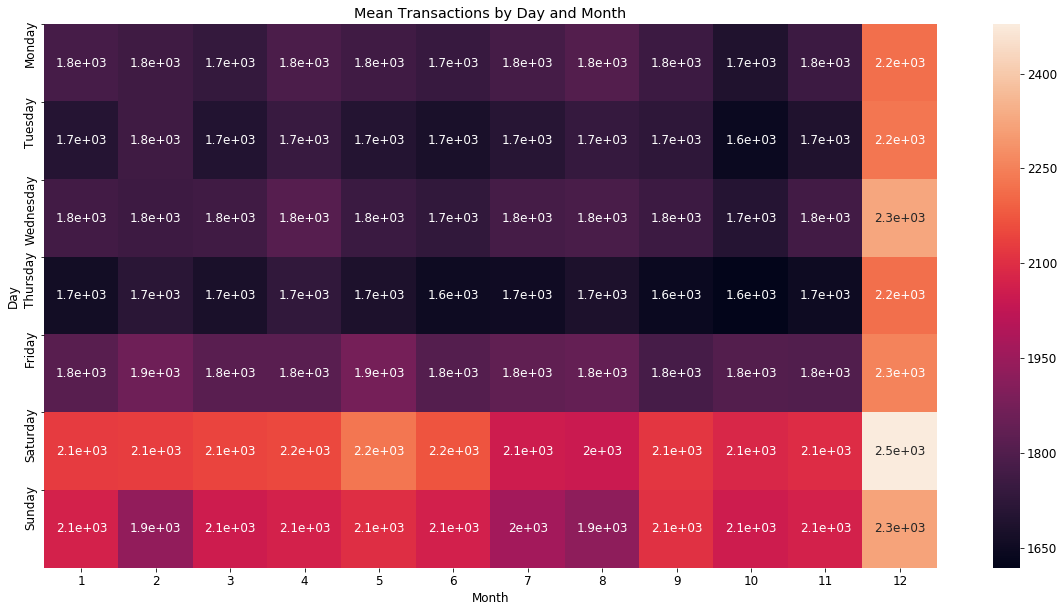

In [253]:
time2 = unitsales[['day','month','transactions']]
time2.reset_index()
time2 = pd.pivot_table(time2, values=['transactions'], index=['day'], columns=['month'], aggfunc=np.mean)
time2 = pd.DataFrame(time2.to_records())
time2.columns = [hdr.replace("('transactions', ","").replace(")", "") for hdr in time2.columns]
time2.drop('day', axis=1, inplace=True)


plt.close('all')
plt.figure(figsize=(20,10))
sns.heatmap(time2, annot=True)
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.yticks(time2.index.values, labels)
plt.ylabel('Day')
plt.xlabel('Month')
plt.title('Mean Transactions by Day and Month')
plt.show()

### Effects of Stores on Unit Sales

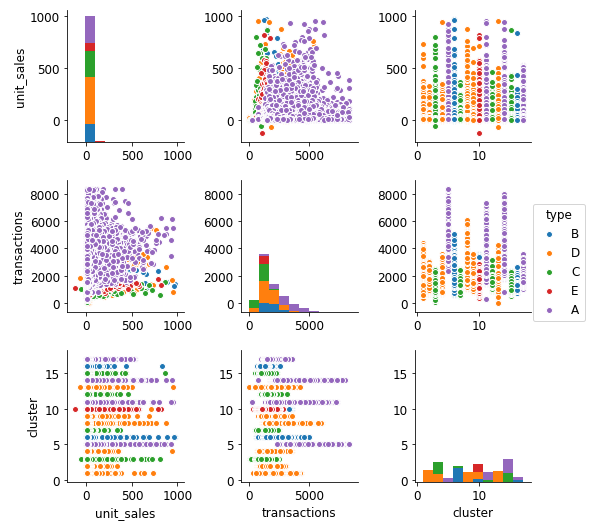

In [320]:
pairs2 = ['unit_sales','transactions','type','cluster']
pair_set2 = unitsales[pairs2].dropna()

plt.close('all')
sns.pairplot(pair_set2, hue='type')
plt.show()

In looking at the differences between the store types, we can see that there is significant overlap between the store types in unit sales. We can also see the overlap in type among the clusters. Cluster does seem to have a relationship to transaction counts, but not unit counts, and this could be a reflection of the fact that most clusters are in a single type.

## Exploration of Oil Prices
In looking at the frequencies of oil barrel prices, it has a binomial distribution.

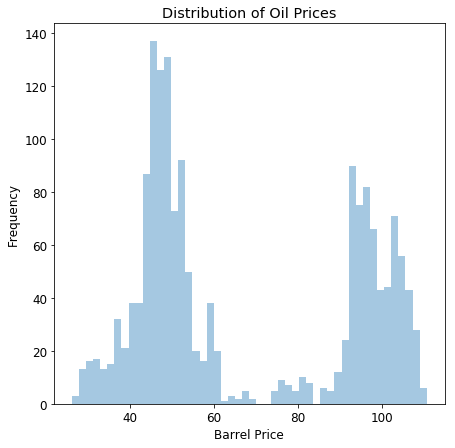

In [303]:
plt.close('all')
fig,ax=plt.subplots(figsize=(7, 7))
sns.distplot(oil['dcoilwtico'].values, bins=50, kde=False)
plt.xlabel('Barrel Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Prices')
plt.show()

Consistent with the binomial distribution, there was a dramatic decrease in oil price in late 2014 that has not been recovered from, as well as a short-term decrease in late 2015/early 2016 that has recovered.

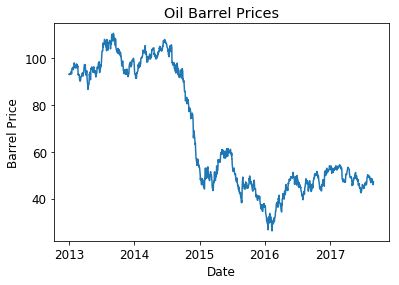

In [301]:
oil['date'] = oil['date'].map(lambda a: datetime.datetime.strptime(a, '%Y-%m-%d'))

plt.close('all')
plt.plot(oil['date'].tolist(), oil['dcoilwtico'])
plt.xlabel('Date')
plt.ylabel('Barrel Price')
plt.title('Oil Barrel Prices')
plt.show()

In looking at the relationship between oil price and the other time series data, there doesn't seem to be an effect on transaction counts, but there does seem to be a joint effect between oil price and whether or not an item is on promotion on the unit sales. However an lmplot reveals that this interaction is not linear.

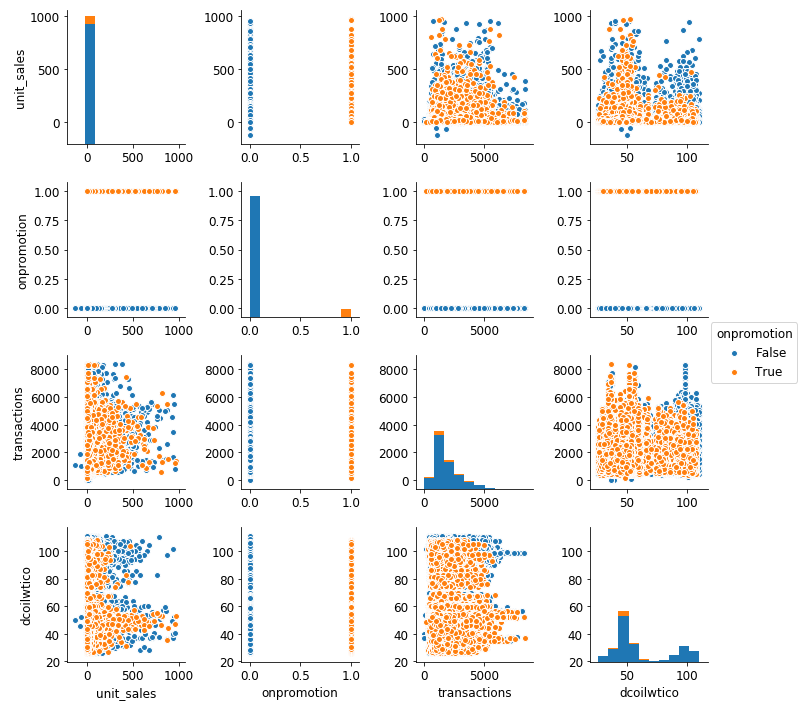

In [304]:
pairs = ['unit_sales','onpromotion','transactions','dcoilwtico']
pair_set = unitsales[pairs].dropna()

plt.close('all')
sns.pairplot(pair_set, hue='onpromotion')
plt.show()

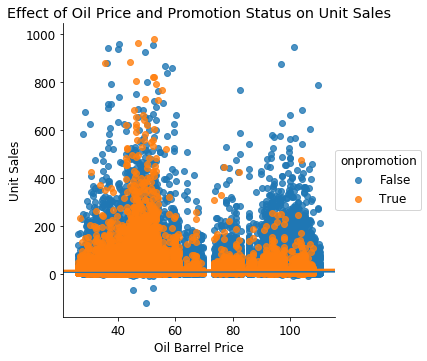

In [329]:
plt.close('all')
sns.lmplot(data = unitsales, x='dcoilwtico', y='unit_sales', hue='onpromotion')
plt.xlabel('Oil Barrel Price')
plt.ylabel('Unit Sales')
plt.title('Effect of Oil Price and Promotion Status on Unit Sales')
plt.show()